In [1]:
import spacy


In [2]:
import spacy
import pandas as pd


In [3]:
cts = pd.read_csv("/home/vs428/project/Moore_data/all_moore_cts.csv", header=None)

In [4]:
cts = cts.rename({0:"KL_ID", 1:"Age", 2:"person_id",3: "CT_Text", 
            4:"Adjudicated_Recommendation", 5:"Model_Recommendation", 6:"Nodule_model",
           7:"Measurement_date", 8:"CT_type"}, axis=1)

In [5]:
spacy.require_gpu()


True

In [6]:
nlp = spacy.load("/home/vs428/project/Moore_models/task_4_textcat_GOLD/model-best", exclude="tagger,parser,attribute_ruler,lemmatizer,ner")
nlp_orig = spacy.load("en_core_web_trf")
nlp.add_pipe("parser", source=nlp_orig, after="transformer")
# nlp.add_pipe("tagger", source=nlp_orig, after="parser")
# nlp.add_pipe("attribute_ruler", source=nlp_orig, after="tagger")
# nlp.add_pipe("lemmatizer", source=nlp_orig, after="attribute_ruler")
# nlp.add_pipe("ner", source=nlp_orig, after="lemmatizer")


/gpfs/milgram/project/rtaylor/vs428/conda_envs/prodigy/lib/python3.9/site-packages/spacy/util.py:865: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.4.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [7]:
config = {"punct_chars": None}
nlp.add_pipe("sentencizer", config=config)


In [8]:
nodule_cts = cts[cts['Nodule_model'] == "Nodule"]

In [9]:
nodule_cts.shape, cts.shape

((10002, 9), (26546, 9))

In [10]:
ct_text = nodule_cts['CT_Text'].tolist()

In [11]:
#[0, 5, 10, 15]

In [12]:
from spacy.matcher import PhraseMatcher
import re
from spacy.matcher import Matcher


In [13]:
def get_previous_sentence_idx(doc, token_index):
    if doc[token_index].sent.start - 1 < 0:
        return 0
    return doc[token_index].sent.start - 1
    # return doc[doc[token_index].sent.start - 1].sent

def get_next_sentence_idx(doc, token_index):
    if doc[token_index].sent.end + 1 >= len(doc):
        return len(doc) - 1
    return doc[token_index].sent.end + 1
    # return doc[doc[token_index].sent.end + 1].sent


def get_context_sents(docs, nlp, patterns=None, context_window=2):
    '''
    docs [spacy Doc form]
    '''
    if patterns is None:
        return docs
    
    matcher = PhraseMatcher(nlp.vocab)    
    patterns_nlp = [nlp.make_doc(text) for text in patterns]    
    matcher.add("TerminologyList", patterns_nlp)
    
    context_sents = []
    for idx, doc in enumerate(docs):
        if idx % 100 == 0:
            print(idx)
        matches = matcher(doc)
        if matches:
            match_id, start, end  = matches[-1]
            enclosing_sent = doc[start:end].sent
            left_sent_bound = start
            right_sent_bound = end

            for context_idx in range(context_window):
                left_sent_bound = get_previous_sentence_idx(doc, left_sent_bound)
                right_sent_bound = get_next_sentence_idx(doc, right_sent_bound)


            context_sents.append(doc[left_sent_bound:right_sent_bound].text)
        else:
            context_sents.append(doc.text)
    return context_sents


In [47]:
nlped_text = nlp.pipe(ct_text)

In [48]:
contexts = get_context_sents(nlped_text, nlp, ["follow","recommend"], context_window=3)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


In [51]:
len(ct_text), len(contexts)

(10002, 10002)

In [49]:
nodule_cts

,KL_ID,Age,person_id,CT_Text,Adjudicated_Recommendation,Model_Recommendation,Nodule_model,Measurement_date,CT_type
1,KL_12943,58,RD_13507,"Reported And Signed By: Amandeep Singh, MD** O...",NO_FOLLOWUP,NO_FOLLOWUP,Nodule,2018-12-01 20:26:00,Custom: IMG3904 CTA CHEST (PE) W IV CONTRAST
3,KL_10419,73,RD_2420,"Reported And Signed By: Balaji Rao, MD** ORIGI...",NO_FOLLOWUP,NO_FOLLOWUP,Nodule,2021-08-18 16:21:00,Custom: IMG3904 CTA CHEST (PE) W IV CONTRAST
5,KL_14218,69,RD_12971,"Reported And Signed By: Balaji Rao, MD** ORIGI...",NO_FOLLOWUP,NO_FOLLOWUP,Nodule,2020-09-14 21:04:00,Custom: IMG3904 CTA CHEST (PE) W IV CONTRAST
6,KL_17076,54,RD_7157,"Reported And Signed By: Balaji Rao, MD********...",HARD_FOLLOWUP,HARD_FOLLOWUP,Nodule,2014-10-09 21:37:00,Custom: IMG3904 CTA CHEST (PE) W IV CONTRAST
12,KL_22173,38,RD_5863,"Reported And Signed By: Jonathan Mezrich, MD**...",NO_FOLLOWUP,NO_FOLLOWUP,Nodule,2020-07-06 08:32:00,Custom: IMG200 CT CHEST WO IV CONTRAST
...,...,...,...,...,...,...,...,...,...
26533,KL_5901,48,RD_4582,Yale Radiology and Biomedical Imaging** ORIGIN...,NO_FOLLOWUP,NO_FOLLOWUP,Nodule,2021-10-11 16:35:00,Custom: IMG3904 CTA CHEST (PE) W IV CONTRAST
26537,KL_10418,54,RD_13408,Yale Radiology and Biomedical Imaging** ORIGIN...,HARD_FOLLOWUP,HARD_FOLLOWUP,Nodule,2021-12-14 13:05:00,Custom: IMG2864 CTA CHEST ABDOMEN W AND/OR WO...
26540,KL_11204,66,RD_14505,Yale Radiology and Biomedical Imaging** ORIGIN...,NO_FOLLOWUP,NO_FOLLOWUP,Nodule,2021-10-20 19:08:00,Custom: IMG206 CTA CHEST W AND/OR WO IV CONTRAST
26542,KL_18709,42,RD_1230,Yale Radiology and Biomedical Imaging** ORIGIN...,CONDITIONAL_FOLLOWUP,HARD_FOLLOWUP,Nodule,2021-11-29 15:59:00,Custom: IMG3904 CTA CHEST (PE) W IV CONTRAST


In [ ]:
# ct_text_cats = []
# for text in contexts:
#     ct_text_cats.append(nlp(text))

In [50]:
# ct_text_cats

In [ ]:
# nodule_cts['CONTEXT_NLP_REC'] = ct_text_cats

In [76]:
IDX = 10

In [84]:
len(contexts), nodule_cts.shape

(10002, (10002, 10))

In [85]:
nodule_cts['CONTEXT_NLP_REC'] = contexts

/tmp/ipykernel_101893/1587333607.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodule_cts['CONTEXT_NLP_REC'] = contexts


In [89]:
nodule_cts.to_csv("/home/vs428/project/Moore_data/all_moore_cts_contexts.csv", index=False)

In [92]:
nodule_cts['Adjudicated_Recommendation'].value_counts(dropna=False)


NO_FOLLOWUP             6968
CONDITIONAL_FOLLOWUP    2001
HARD_FOLLOWUP           1033
Name: Adjudicated_Recommendation, dtype: int64

In [14]:
# from spacy.tokens import DocBin

In [15]:
# db = DocBin()
# for text, annotations in training_data:
#     doc = nlp(text)
#     ents = []
#     for start, end, label in annotations:
#         span = doc.char_span(start, end, label=label)
#         ents.append(span)
#     doc.ents = ents
#     db.add(doc)
# db.to_disk("./train.spacy")

In [16]:
nodule_cts = pd.read_csv("/home/vs428/project/Moore_data/all_moore_cts_contexts.csv")

In [18]:
labels = pd.read_csv("/home/vs428/project/Moore_data/moore_ct_labels.csv", header=None)

In [20]:
labels[1].value_counts()


No follow up             25
Known malignancy         15
Hard follow up           13
Conditional follow up     9
New malignancy            6
Non lung follow up        1
Name: 1, dtype: int64

In [28]:
import jsonlines
from collections import Counter

In [23]:
lines = []
with jsonlines.open("/home/vs428/scratch60/Kevin_backup/prodigy/annotations/ct_images_75_25_500_TASK4_GOLD.jsonl") as reader:
    for line in reader:
        lines.append(line)

In [25]:
print(len(lines))

501


In [34]:
Counter([line['accept'][0] for line in lines])

Counter({'NO_FOLLOWUP': 274,
         'CONDITIONAL_FOLLOWUP': 122,
         'HARD_FOLLOWUP': 105})

In [61]:
labeled_texts = [line['text'] for line in lines]

In [62]:
nlped_labeled_text = nlp.pipe(labeled_texts)

In [63]:
# get_context_sents(nlped_labeled_text, nlp, patterns=None, context_window=2):
contexts = get_context_sents(nlped_labeled_text, nlp, ["follow","recommend"], context_window=4)

0
100
200
300
400
500


In [66]:
context_lines = lines.copy()

In [69]:
for line, context_line in zip(context_lines, contexts):
    line['text'] = context_line

In [73]:
with jsonlines.open("/home/vs428/scratch60/Kevin_backup/prodigy/annotations/ct_images_75_25_500_TASK4_GOLD_contexts.jsonl", "w") as writer:
    writer.write_all(context_lines)
    # for line in reader:
    #     lines.append(line)

In [74]:
context_lines[0]

{'text': "CTA CHEST (PE) W IV CONTRAST  INDICATION: Sudden onset left-sided chest pain starting yesterday evening, history of aortic root and ascending aortic aneurysm  COMPARISON: 3/14/2019, 11/4/2014  TECHNIQUE: CT images of the chest were obtained from the lung bases through the apices after the intravenous administration of 80cc of Omnipaque-350 contrast. Coronal and oblique 3D/MIPS reformats are provided.   FINDINGS: There is no evidence of filling defects in the pulmonary arteries to suspect pulmonary embolism.  These findings were corroborated in the MIP images.   The heart is enlarged. The mid ascending thoracic aorta measures up to 4.7 cm, previously measuring up to 4.6 cm. Left main coronary ectasia/prominent infundibulum is redemonstrated. There is no aneurysm or dissection of the thoracic aorta.   There is a 7 mm perifissural oblong nodule (image 204 series 3) which is stable since the study in 2014, likely representing a node. There is posterior dependent atelectasis. Ther

In [1]:
import pandas as pd

In [2]:
cts = pd.read_csv("/home/vs428/project/Moore_data/all_moore_cts.csv")

In [5]:
cts

,KL_ID,Age,person_id,CT_Text,Adjudicated_Recommendation,Model_Recommendation,Nodule_model,Measurement_date,CT_type
0,KL_12943,58,RD_13507,"Reported And Signed By: Amandeep Singh, MD** O...",NO_FOLLOWUP,NO_FOLLOWUP,Nodule,2018-12-01 20:26:00,Custom: IMG3904 CTA CHEST (PE) W IV CONTRAST
1,KL_14997,86,RD_10347,"Reported And Signed By: Balaji Rao, MD** ORIGI...",NO_FOLLOWUP,NO_FOLLOWUP,No Nodule,2018-11-28 08:41:00,Custom: IMG1428 CT CHEST ABDOMEN PELVIS W IV ...
2,KL_10419,73,RD_2420,"Reported And Signed By: Balaji Rao, MD** ORIGI...",NO_FOLLOWUP,NO_FOLLOWUP,Nodule,2021-08-18 16:21:00,Custom: IMG3904 CTA CHEST (PE) W IV CONTRAST
3,KL_22683,59,RD_203,"Reported And Signed By: Balaji Rao, MD** ORIGI...",NO_FOLLOWUP,NO_FOLLOWUP,No Nodule,2021-04-14 19:55:00,Custom: IMG206 CTA CHEST W AND/OR WO IV CONTRAST
4,KL_14218,69,RD_12971,"Reported And Signed By: Balaji Rao, MD** ORIGI...",NO_FOLLOWUP,NO_FOLLOWUP,Nodule,2020-09-14 21:04:00,Custom: IMG3904 CTA CHEST (PE) W IV CONTRAST
...,...,...,...,...,...,...,...,...,...
26540,KL_24924,48,RD_4586,Yale Radiology and Biomedical Imaging** ORIGIN...,NO_FOLLOWUP,NO_FOLLOWUP,No Nodule,2021-10-03 05:03:00,Custom: IMG206 CTA CHEST W AND/OR WO IV CONTRAST
26541,KL_18709,42,RD_1230,Yale Radiology and Biomedical Imaging** ORIGIN...,CONDITIONAL_FOLLOWUP,HARD_FOLLOWUP,Nodule,2021-11-29 15:59:00,Custom: IMG3904 CTA CHEST (PE) W IV CONTRAST
26542,KL_532,38,RD_1332,"\ CT CHEST ABDOMEN PELVIS W IV CONTRAST, CT 2D...",NO_FOLLOWUP,NO_FOLLOWUP,No Nodule,2020-05-11 01:22:00,Custom: IMG1428 CT CHEST ABDOMEN PELVIS W IV ...
26543,KL_6441,32,RD_9508,dd CTA CHEST (PE) W IV CONTRAST INDICATION: C...,NO_FOLLOWUP,NO_FOLLOWUP,No Nodule,2018-07-19 06:18:00,Custom: IMG3904 CTA CHEST (PE) W IV CONTRAST


# Inference on Dev Set (Follow up IMPRESSION ONLY)

In [3]:
import spacy
from spacy.training import Corpus
from spacy.tokens import DocBin

import pandas as pd

In [4]:

# doc_bin = DocBin().from_disk("/home/vs428/project/Moore_data/followup_impression_data/dev.spacy")
doc_bin = DocBin().from_disk("/home/vs428/project/Moore_data/followup_impression_data_1_11_2023/dev.spacy")

In [9]:
from spacy.language import Language
from Weighted_TextCategorizer import TextCategorizer

In [10]:
Language.factories['weighted_textcat'] = lambda nlp, **cfg: Weighted_TextCategorizer(nlp, **cfg) 

NotImplementedError: [E957] Writing directly to `Language.factories` isn't needed anymore in spaCy v3. Instead, you can use the `@Language.factory` decorator to register your custom component factory or `@Language.component` to register a simple stateless function component that just takes a Doc and returns it.

In [11]:
nlp = spacy.load("/home/vs428/Documents/Moore/followup_model/model-best", exclude="tagger,parser,attribute_ruler,lemmatizer,ner")
nlp_orig = spacy.load("en_core_web_trf")
nlp.add_pipe("parser", source=nlp_orig, after="transformer")
# nlp = spacy.load("en-pipeline")
# nlp.add_pipe("tagger", source=nlp_orig, after="parser")
# nlp.add_pipe("attribute_ruler", source=nlp_orig, after="tagger")
# nlp.add_pipe("lemmatizer", source=nlp_orig, after="attribute_ruler")
# nlp.add_pipe("ner", source=nlp_orig, after="lemmatizer")


class weights: [ 1. 75. 24.]


In [12]:
docs = list(doc_bin.get_docs(nlp.vocab))

In [13]:
for doc in docs:
    doc.cats = {}

In [14]:
# taken from https://stackoverflow.com/a/44764557/1726404
'''
This works by using nlp.pipe and putting our records into tuples. We process it as tuples and get the context
In our work, the context is just the study id. 
We get the entity text, label, start and stop characters for each entity
we convert that to a json string, we then put the [context,json] together into a list
append this list to nlp_out
then turn nlp out into a df with 1 col being study id and the other being the nlp out
Finally we merge the df with our main data df. Now we have a column with the text
'''
import json
nlp_out = []
count = 0
for doc in nlp.pipe(docs):
    out_ = doc.cats
    nlp_out.append(json.dumps(out_, indent = 2))
    print(count)
    count +=1
nlp_df = pd.DataFrame(nlp_out, columns=['NLP_OUT'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


In [15]:

x = [doc.text for doc in docs]

In [16]:
nlp_df

,NLP_OUT
0,"{\n ""NO_FOLLOWUP"": 0.0005270380643196404,\n ..."
1,"{\n ""NO_FOLLOWUP"": 0.9994357228279114,\n ""HA..."
2,"{\n ""NO_FOLLOWUP"": 0.000327683228533715,\n ""..."
3,"{\n ""NO_FOLLOWUP"": 0.9993839263916016,\n ""HA..."
4,"{\n ""NO_FOLLOWUP"": 0.000575861893594265,\n ""..."
...,...
146,"{\n ""NO_FOLLOWUP"": 0.0005675480351783335,\n ..."
147,"{\n ""NO_FOLLOWUP"": 0.00031567655969411135,\n ..."
148,"{\n ""NO_FOLLOWUP"": 0.9994366765022278,\n ""HA..."
149,"{\n ""NO_FOLLOWUP"": 0.0002979820128530264,\n ..."


In [17]:
# docs_with_anns = nlp.pipe(docs[:5], as_tuples=True, batch_size=50, n_process=1)
nlp_df['TEXT'] = x

In [18]:
def extract_prodigy_vals(x, col_name):
    tmp = eval(x[col_name])
    pred = max(tmp, key=tmp.get)
    score = tmp[pred]
    return pred, score



In [19]:
testout = nlp_df.apply(extract_prodigy_vals, axis=1, col_name="NLP_OUT", result_type="expand")

In [20]:
nlp_df = pd.concat([nlp_df, testout], axis=1)

In [21]:
# def get_ids_on_orig_data(data_in, anns, 
#                          data_text_col_name, ann_text_col_name, data_ID_col, 
#                          threshold=99, verbose=False):
#     '''Given the original set of data and a set of annotations (with text!), return a merged version of 
#     annotations that have the ID column inserted into the annotations for downstream processing
#     '''
#     for idx, ann in enumerate(anns):
#         if verbose:
#             if idx % 10 == 0:
#                 print(idx/len(anns))
#         ratios = data_in[data_text_col_name].apply(lambda row: fuzz.ratio(ann[ann_text_col_name], row))
#         if ratios[ratios > threshold].shape[0] != 1:
#             print(ratios[ratios >= threshold])
#             print(data_in[ratios >= threshold][data_ID_col])
#             raise Exception("Uh-oh")
#         # assert(ratios[ratios > threshold].shape[0] == 1)
#         if "meta" not in ann.keys():
#             ann['meta'] = {}

#         ann['meta'][data_ID_col] = data_in[ratios >= threshold][data_ID_col]
    
#     return anns


In [22]:
nlp_df

,NLP_OUT,TEXT,0,1
0,"{\n ""NO_FOLLOWUP"": 0.0005270380643196404,\n ...",Non-specific lung nodules which measure 4 mm ...,CONDITIONAL_FOLLOWUP,0.999274
1,"{\n ""NO_FOLLOWUP"": 0.9994357228279114,\n ""HA...",IMPRESSION: 1. No evidence of pulmonary embol...,NO_FOLLOWUP,0.999436
2,"{\n ""NO_FOLLOWUP"": 0.000327683228533715,\n ""...",IMPRESSION: No evidence of pulmonary embolis...,HARD_FOLLOWUP,0.999053
3,"{\n ""NO_FOLLOWUP"": 0.9993839263916016,\n ""HA...",IMPRESSION: Type A aortic dissection with vess...,NO_FOLLOWUP,0.999384
4,"{\n ""NO_FOLLOWUP"": 0.000575861893594265,\n ""...",. Evaluation of the more distal pulmonary tree...,CONDITIONAL_FOLLOWUP,0.999252
...,...,...,...,...
146,"{\n ""NO_FOLLOWUP"": 0.0005675480351783335,\n ...",CTA CHEST (PE) W IV CONTRAST INDICATION: Pulmo...,CONDITIONAL_FOLLOWUP,0.999255
147,"{\n ""NO_FOLLOWUP"": 0.00031567655969411135,\n ...",Bones and Soft Tissues: No acute fracture or ...,HARD_FOLLOWUP,0.999075
148,"{\n ""NO_FOLLOWUP"": 0.9994366765022278,\n ""HA...",IMPRESSION: 1. Left lower lobe segmental pulm...,NO_FOLLOWUP,0.999437
149,"{\n ""NO_FOLLOWUP"": 0.0002979820128530264,\n ...",Impression: 1. No visceral organ injury. No ev...,HARD_FOLLOWUP,0.999134


In [23]:

from fuzzywuzzy import fuzz
import jsonlines
anns = []
with jsonlines.open("/home/vs428/project/Moore_data/followup_pipeline_v3_impressions.jsonl") as reader:
    for line in reader:
        anns.append(line)

In [24]:
len(anns)

1101

In [25]:
nlp_df.iloc[0]

NLP_OUT    {\n  "NO_FOLLOWUP": 0.0005270380643196404,\n  ...
TEXT        Non-specific lung nodules which measure 4 mm ...
0                                       CONDITIONAL_FOLLOWUP
1                                                   0.999274
Name: 0, dtype: object

In [26]:
import ast

In [27]:
no_followup = []
hard_followup = []
cond_followup = []
for idx, row in nlp_df.iterrows():
    # print(row)
    no_followup.append(ast.literal_eval(row['NLP_OUT'])['NO_FOLLOWUP'])
    hard_followup.append(ast.literal_eval(row['NLP_OUT'])['HARD_FOLLOWUP'])
    cond_followup.append(ast.literal_eval(row['NLP_OUT'])['CONDITIONAL_FOLLOWUP'])
    #['NLP_OUT']

In [28]:
nlp_df['COND'] = cond_followup
nlp_df['HARD'] = hard_followup
nlp_df['NO'] = no_followup


In [29]:
anns_df = pd.DataFrame.from_records(anns)

In [30]:
anns_df

,text,_input_hash,_task_hash,options,_view_id,config,accept,answer,_timestamp,_annotator_id,_session_id,sessions,view_id
0,IMPRESSION: 1. No evidence of pulmonary embo...,-1983226661,-941005989,"[{'id': 'NO_FOLLOWUP', 'text': 'NO_FOLLOWUP'},...",choice,{'choice_style': 'single'},[NO_FOLLOWUP],accept,1657744578,ct_images_75_25_500_TASK4-rat4,ct_images_75_25_500_TASK4-rat4,"[ct_images_75_25_500_TASK4-rat4, ct_images_75_...",choice
1,IMPRESSION: No evidence of pulmonary embolus....,1808797508,-1673251006,"[{'id': 'NO_FOLLOWUP', 'text': 'NO_FOLLOWUP'},...",choice,{'choice_style': 'single'},[NO_FOLLOWUP],accept,1657744587,ct_images_75_25_500_TASK4-rat4,ct_images_75_25_500_TASK4-rat4,"[ct_images_75_25_500_TASK4-rat4, ct_images_75_...",choice
2,IMPRESSION: 1. Acute non-to-minimally displac...,-630307167,-803402197,"[{'id': 'NO_FOLLOWUP', 'text': 'NO_FOLLOWUP'},...",choice,{'choice_style': 'single'},[NO_FOLLOWUP],accept,1657744623,ct_images_75_25_500_TASK4-rat4,ct_images_75_25_500_TASK4-rat4,"[ct_images_75_25_500_TASK4-rat4, ct_images_75_...",choice
3,. Likely subacute fracture of spinous process ...,-474162194,1530266395,"[{'id': 'NO_FOLLOWUP', 'text': 'NO_FOLLOWUP'},...",choice,{'choice_style': 'single'},[CONDITIONAL_FOLLOWUP],accept,1657744634,ct_images_75_25_500_TASK4-rat4,ct_images_75_25_500_TASK4-rat4,"[ct_images_75_25_500_TASK4-rat4, ct_images_75_...",choice
4,IMPRESSION: No evidence of pulmonary embolism....,1095647110,1318298090,"[{'id': 'NO_FOLLOWUP', 'text': 'NO_FOLLOWUP'},...",choice,{'choice_style': 'single'},[NO_FOLLOWUP],accept,1657744642,ct_images_75_25_500_TASK4-rat4,ct_images_75_25_500_TASK4-rat4,"[ct_images_75_25_500_TASK4-rat4, ct_images_75_...",choice
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,IMPRESSION: No evidence of pulmonary embolism...,-1203340127,130017192,"[{'id': 'NO_FOLLOWUP', 'text': 'NO_FOLLOWUP'},...",choice,{'choice_style': 'single'},[NO_FOLLOWUP],accept,1673016987,followup_pipeline_v1-rdenkewicz,followup_pipeline_v1-rdenkewicz,NaN,NaN
1097,IMPRESSION: 1. No evidence of pulmonary embol...,-1827809163,256471539,"[{'id': 'NO_FOLLOWUP', 'text': 'NO_FOLLOWUP'},...",choice,{'choice_style': 'single'},[],ignore,1673017025,followup_pipeline_v1-rdenkewicz,followup_pipeline_v1-rdenkewicz,NaN,NaN
1098,IMPRESSION: Increase size of a 2.1 x 1.1 cm l...,-1102992877,-809610587,"[{'id': 'NO_FOLLOWUP', 'text': 'NO_FOLLOWUP'},...",choice,{'choice_style': 'single'},[HARD_FOLLOWUP],accept,1673017047,followup_pipeline_v1-rdenkewicz,followup_pipeline_v1-rdenkewicz,NaN,NaN
1099,IMPRESSION: Right apical paramediastinal lesi...,-499169908,446934794,"[{'id': 'NO_FOLLOWUP', 'text': 'NO_FOLLOWUP'},...",choice,{'choice_style': 'single'},[],ignore,1673017099,followup_pipeline_v1-rdenkewicz,followup_pipeline_v1-rdenkewicz,NaN,NaN


In [31]:
data_text_col_name = "TEXT"
ann_text_col_name = "text"
threshold = 99
# id_output = []
gold_ann = []
# data_ID_col
for idx, nlp_row in nlp_df.iterrows():
    ratios = anns_df[ann_text_col_name].apply(lambda row: fuzz.ratio(nlp_row['TEXT'], row))
    # print(anns_df.iloc[ratios.idxmax()])
    gold_ann.append(anns_df.iloc[ratios.idxmax()]['accept'])
    # ann['meta'][data_ID_col] = nlp_df[ratios >= threshold][data_ID_col]
# for idx, ann in enumerate(anns):
#     ratios = nlp_df[data_text_col_name].apply(lambda row: fuzz.ratio(ann[ann_text_col_name], row))
#     print(len(ratios))
#     if "meta" not in ann.keys():
#         ann['meta'] = {}
#     for ratio in ratios.iterrows():
        
    # ann['meta'][data_ID_col] = nlp_df[ratios >= threshold][data_ID_col]
    

In [32]:
nlp_df['gold_ann'] = gold_ann

In [33]:
nlp_df['gold_ann']

0      [CONDITIONAL_FOLLOWUP]
1               [NO_FOLLOWUP]
2             [HARD_FOLLOWUP]
3               [NO_FOLLOWUP]
4      [CONDITIONAL_FOLLOWUP]
                ...          
146    [CONDITIONAL_FOLLOWUP]
147           [HARD_FOLLOWUP]
148             [NO_FOLLOWUP]
149           [HARD_FOLLOWUP]
150           [HARD_FOLLOWUP]
Name: gold_ann, Length: 151, dtype: object

In [34]:
nlp_df['y_true'] = nlp_df.apply(lambda row: row['gold_ann'][0], axis=1)

In [35]:
nlp_df = nlp_df.rename({0:"y_pred", 1:"y_prob"}, axis=1)

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay

In [37]:
# fig, [ax_roc, ax_det, ax_pr] = plt.subplots(1, 3, figsize=(20, 5))

# RocCurveDisplay.from_predictions(nlp_df['y_true'], nlp_df['y_prob'], ax=ax_roc,)# name=name)
# DetCurveDisplay.from_predictions(nlp_df['y_true'], nlp_df['y_prob'], ax=ax_det)#, name=name)
# PrecisionRecallDisplay.from_predictions(nlp_df['y_true'], nlp_df['y_prob'], ax=ax_pr)


In [38]:
def plot_multiclass_pr_from_preds(y_test, y_pred, 
                        title="PR Curve", labels=None, figsize=(8, 6)):

    # structures
    precision = dict()
    recall = dict()

    n_classes = y_pred.shape[1]
    assert y_pred.shape[1] >= np.max(y_test)

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False)
    y_test_dummies_vals = y_test_dummies.values
    
    average_precision = average_precision_score(y_test_dummies_vals, y_pred, average=None)
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_dummies_vals[:, i], y_pred[:, i])
        # print(precision[i][-50:], recall[i][-50:])
        
    # pr for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0.5, 0.5], 'k--')
    ax.set_xlim([0.0, 1.05])
    ax.set_ylim([0.5, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)

    if labels:
        for i, label in zip(range(n_classes), labels):
            ax.plot(precision[i], recall[i], label=f'PR curve (AP = {average_precision[i]:.2f}) for {label}')
    else:
        for i in range(n_classes):
            ax.plot(precision[i], recall[i], label=f'PR curve (AP = {average_precision[i]:.2f}) for label {i}')
        
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

def plot_multiclass_roc_from_preds(y_test, y_pred,
                        title="ROC Curve", labels=None, figsize=(8, 6)):

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    n_classes = 3#y_pred.shape[1]
    # assert y_pred.shape[1] >= np.max(y_test)
    
    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False)
    y_test_dummies_vals = y_test_dummies.values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies_vals[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    if labels:
        for i, label in zip(range(n_classes), labels):
            ax.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for {label}')
    else:
        for i in range(n_classes):
            ax.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for label {i}')
        
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    # sns.despine()
    plt.show()


In [39]:
pd.get_dummies(nlp_df['y_true'], drop_first=False)

,CONDITIONAL_FOLLOWUP,HARD_FOLLOWUP,NO_FOLLOWUP
0,1,0,0
1,0,0,1
2,0,1,0
3,0,0,1
4,1,0,0
...,...,...,...
146,1,0,0
147,0,1,0
148,0,0,1
149,0,1,0


In [40]:
import sklearn
# import seaborn as sns; sns.set_style("ticks")
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve, CalibrationDisplay


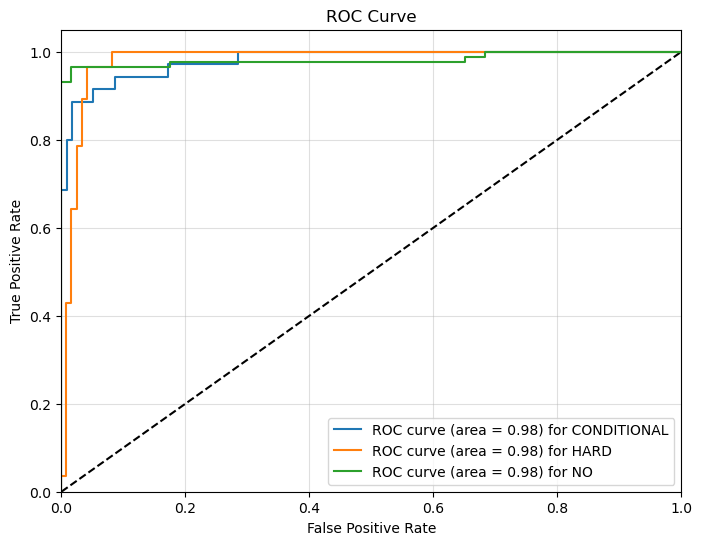

In [41]:
plot_multiclass_roc_from_preds(nlp_df['y_true'], nlp_df[['COND','HARD' ,'NO']].values, labels=["CONDITIONAL", "HARD", "NO"])



In [42]:
import numpy as np
nlp_df['label_simple'] = np.where((nlp_df['y_true'] == "CONDITIONAL_FOLLOWUP") | (nlp_df['y_true'] == "HARD_FOLLOWUP"), "FOLLOW_UP", "NO_FOLLOWUP")
nlp_df['ypred_simple'] = np.where((nlp_df['y_pred'] == "CONDITIONAL_FOLLOWUP") | (nlp_df['y_pred'] == "HARD_FOLLOWUP"), "FOLLOW_UP", "NO_FOLLOWUP")


Text(0, 0.5, 'True Follow-Up Label (from Ryan)')

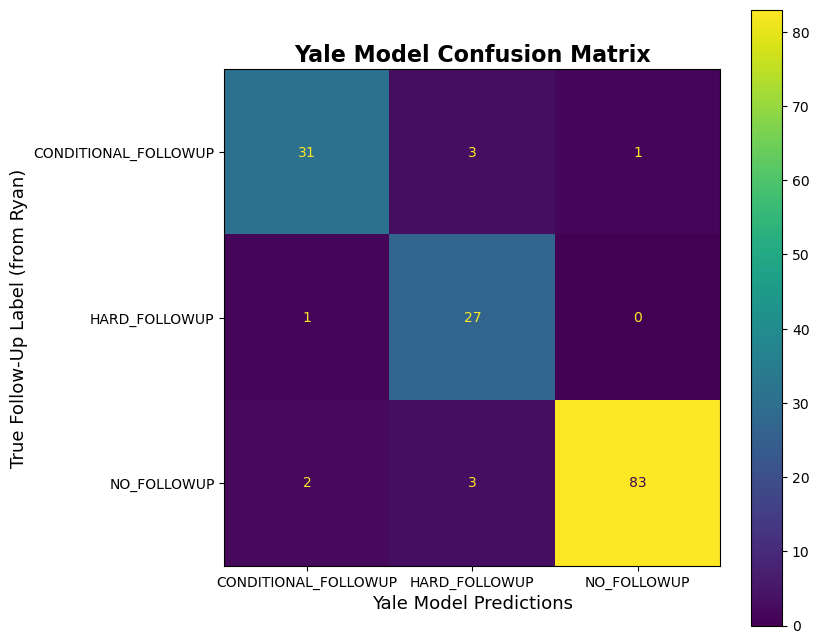

In [43]:
fig, ax = plt.subplots(figsize = (8,8))
ax.set_title("Yale Model Confusion Matrix", fontsize=16, fontweight="bold")

ConfusionMatrixDisplay.from_predictions(nlp_df['y_true'], nlp_df['y_pred'], ax=ax)

ax.set_xlabel("Yale Model Predictions", fontsize=13)
ax.set_ylabel("True Follow-Up Label (from Ryan)", fontsize=13)

Text(0, 0.5, 'True Follow-Up Label (from Ryan)')

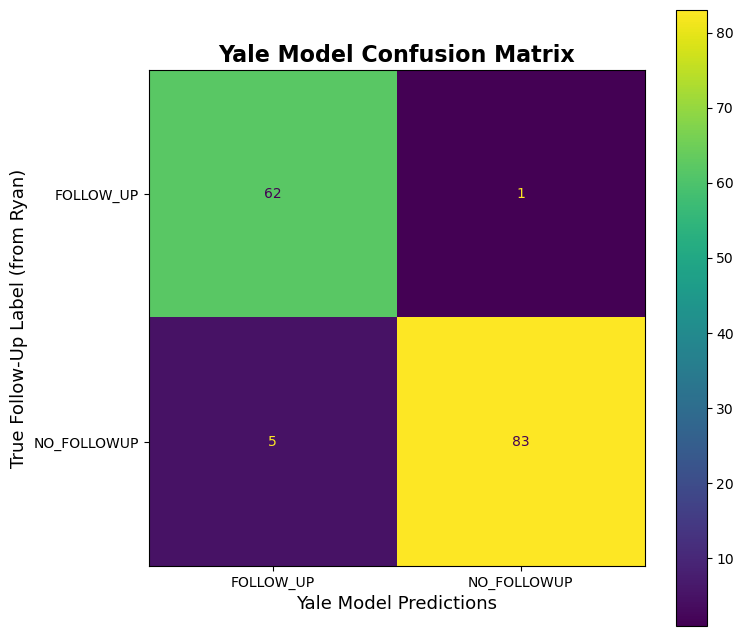

In [44]:
fig, ax = plt.subplots(figsize = (8,8))
ax.set_title("Yale Model Confusion Matrix", fontsize=16, fontweight="bold")

ConfusionMatrixDisplay.from_predictions(nlp_df['label_simple'], nlp_df['ypred_simple'], ax=ax)

ax.set_xlabel("Yale Model Predictions", fontsize=13)
ax.set_ylabel("True Follow-Up Label (from Ryan)", fontsize=13)

In [45]:
# nlp_df.to_csv("/home/vs428/Documents/Moore/cancer_spacy_data/misclassified_cts_impression.csv", index=False)